In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from scipy import stats

plt.rcParams.update({'font.size': 16,
                   'xtick.labelsize':14,
                   'ytick.labelsize':14,
                    "legend.title_fontsize":14})

# Notebook 5: weathering reaction model

This notebook outlines simple weathering reaction models that are transformed by simple transit time distributions (TTD) to explore the relationship between weathering product concentration and young water fraciton F$_{\mathrm{yw}}$.

In [2]:
### define a piecewise linear function for weathering, C vs. T
## teq is equilibrium time, tinit is time of initiation of reaction
def linearweathering(t,teq,tinit):
    result = []
    for ti in t:
        if ti<tinit:
            c = 0
        elif (ti>=tinit) & (ti<teq):
            c = (ti-tinit)/(teq-tinit)
        else:
            c = 1
        result.append(c)
    return result

In [3]:
### generate normal distributions for young and old endmember
# young water: 50 days +/- 15
mean_age_youngwater = 50
sd_age_youngwater = 15
# old water: 270 days +/-80
mean_age_oldwater = 270
sd_age_oldwater = 80

# array of ages
tplot = range(0,600)

# generate pdfs
pdf_young = stats.norm.pdf(tplot,loc=mean_age_youngwater,scale=sd_age_youngwater)
pdf_old = stats.norm.pdf(tplot,loc=mean_age_oldwater,scale=sd_age_oldwater)

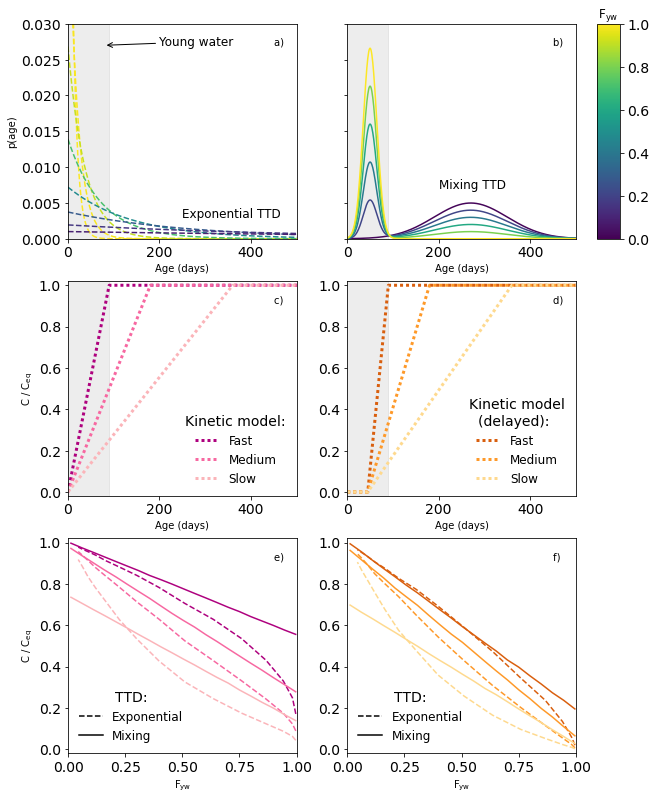

In [4]:
plt.rcParams.update({'font.size': 16,
                   'xtick.labelsize':14,
                   'ytick.labelsize':14,
                    "legend.title_fontsize":14})

randomnums = int(100000)

gridspec = {'width_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(3, 3, figsize=(9,11), gridspec_kw=gridspec,constrained_layout=True)
ax = ax.flatten()

ax[5].axis('off')
ax[8].axis('off')


## subplot a: exponential TTDs
tplot = range(0,600)
meanages_plot = np.logspace(1,3,15)[::2]

for i,val in enumerate(meanages_plot):
    # exponential (gamma with a=1)
    # calculate Fyw for color coding
    fyw_temp = stats.gamma.cdf(90,a=1,scale=val) 
    ax[0].plot(stats.gamma.pdf(tplot,a=1,scale=val),c=cm.viridis(fyw_temp),ls='--',zorder=2)

## subplot b: mixing TTDs
mixingfractions_plot = np.arange(0,1.2,0.2)
mixingfractions = np.arange(0,1.05,0.05)

for i,val in enumerate(mixingfractions_plot):
    pdf_temp = pdf_young*val+pdf_old*(1-val)
    fyw_temp = np.cumsum(pdf_temp)[90]
    
    ax[1].plot(pdf_temp,c=cm.viridis(fyw_temp))

# add colorbar for b (and a)
cb = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), cax = ax[2], orientation = 'vertical')
cb.ax.set_title('F$_{\mathrm{yw}}$')
    
## subplot c (and e): chemical reation profiles
age_threshold=90
teqs = age_threshold*np.array([1,2,4]) # set equilibrium times to 1x, 2x and 4x the Fyw threshold
tinits = np.array([0,0,0]) # set initiation time to zero for plot c

# set colors
ccolors = ['#ae017e','#f768a1','#fbb4b9']
ccolors2 = ['#d95f0e','#fe9929','#fed98e']

for i in range(0,len(teqs)):
    
    # plot weathering reaction over time in subplot c
    ax[3].plot(tplot,linearweathering(tplot,teqs[i],tinits[i]),c=ccolors[i],ls=(0, (1, 1)),linewidth=3)
    
    # combine with exponential TTDs in subplot a to make C-Fyw relationships in subplot e
    fyw_exp = []
    c_exp = []
    meanages = np.logspace(1.2,3.3,15)
    for j in meanages:
        # random sampling from exponential TTD
        rvs_temp = stats.expon.rvs(scale=j,size=int(randomnums/10))
        # record Fyw
        fyw_exp.append(stats.expon.cdf(90,scale=j))
        # record C (put random TTD samples through the weathering reaction C vs. t realtionship)
        c_exp.append(np.mean(linearweathering(rvs_temp,teq=teqs[i],tinit=tinits[i])))
    
    # plot C-Fyw in subplot e
    ax[6].plot(fyw_exp,c_exp,ls='--',c=ccolors[i])
    
    # now combine with mixing TTDs to make C-Fyw relationships in subpot e
    fyw_mix = []
    c_mix = []
    for m in mixingfractions:
        # make pdf from young and old mixing fraction
        pdf_temp = pdf_young*m+pdf_old*(1-m)
        # record Fyw
        fyw_mix.append(np.cumsum(pdf_temp)[90])
        # random sample from pdf
        rvs_temp = np.random.choice(tplot, size=randomnums, p=pdf_temp/np.sum(pdf_temp)) 
        # record C (put random TTD samples through the weathering reaction C vs. t realtionship)
        c_mix.append(np.mean(linearweathering(rvs_temp,teq=teqs[i],tinit=tinits[i])))
    
    # plot C-Fyw in subpot e
    ax[6].plot(fyw_mix,c_mix,c=ccolors[i])


## subplot d (and f): chemical reation profiles with delayed initiation
tinits = np.array([45,45,45]) # initiate 45 days in, halfway to Fyw threshold
for i in range(0,len(teqs)):
    # plot weathering reaction over time in subplot d
    ax[4].plot(tplot,linearweathering(tplot,teqs[i],tinits[i]),c=ccolors2[i],ls=(0, (1, 1)),linewidth=3)
    
    # combine with exponential TTDs in subplot a to make C-Fyw relationships in subplot f
    fyw_exp = []
    c_exp = []
    for j in meanages:
        # random sampling from exponential TTD
        rvs_temp = stats.expon.rvs(scale=j,size=int(randomnums/10))
        # record Fyw
        fyw_exp.append(stats.expon.cdf(90,scale=j))
        # record C (put random TTD samples through the weathering reaction C vs. t realtionship)
        c_exp.append(np.mean(linearweathering(rvs_temp,teq=teqs[i],tinit=tinits[i])))
        
    # plot C-Fyw in subplot f
    ax[7].plot(fyw_exp,c_exp,ls='--',c=ccolors2[i])
    
    # now combine with mixing TTDs to make C-Fyw relationships in subpot e
    fyw_mix = []
    c_mix = []
    for m in mixingfractions:
        # make pdf from young and old mixing fraction
        pdf_temp = pdf_young*m+pdf_old*(1-m)
        # record Fyw
        fyw_mix.append(np.cumsum(pdf_temp)[90])
        # random sample from pdf
        rvs_temp = np.random.choice(tplot, size=randomnums, p=pdf_temp/np.sum(pdf_temp)) 
        # record C (put random TTD samples through the weathering reaction C vs. t realtionship)
        c_mix.append(np.mean(linearweathering(rvs_temp,teq=teqs[i],tinit=tinits[i])))
        
    # plot C-Fyw in subplot f
    ax[7].plot(fyw_mix,c_mix,c=ccolors2[i])
    
# labels
letters = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']
figlabels = ['','','','','','','','','','','']
[ax[num].text(0.90,0.90,letters[i]+figlabels[i],transform = ax[num].transAxes) for i,num in enumerate([0,1,3,4,6,7])]

# add patch to show young water threshold of 90 days
ax[0].add_patch(Rectangle((0,0),90,0.03,color='k',alpha=0.07,zorder=0))
ax[1].add_patch(Rectangle((0,0),90,0.03,color='k',alpha=0.07,zorder=0))
ax[3].add_patch(Rectangle((0,-0.02),90,1.04,color='k',alpha=0.07,zorder=0))
ax[4].add_patch(Rectangle((0,-0.02),90,1.04,color='k',alpha=0.07,zorder=0))


# limits, labels
ax[0].set_ylim([0,0.03])
ax[0].set_xlim([-0.1,500.1])
ax[1].set_ylim([0,0.03])
ax[1].set_xlim([-0.1,500.1])

ax[1].set_yticklabels([])

ax[0].set_ylabel('p(age)')
ax[0].set_xlabel('Age (days)')
ax[1].set_xlabel('Age (days)')

ax[3].set_xlim([-0.1,500.1])
ax[4].set_xlim([-0.1,500.1])
ax[3].set_ylim([-0.02,1.02])
ax[4].set_ylim([-0.02,1.02])

ax[3].set_ylabel('C / C$_{\mathrm{eq}}$')
ax[3].set_xlabel('Age (days)')
ax[4].set_xlabel('Age (days)')

ax[6].set_xlim([-0.001,1.001])
ax[7].set_xlim([-0.001,1.001])

ax[6].set_ylim([-0.02,1.02])
ax[7].set_ylim([-0.02,1.02])

ax[6].set_ylabel('C / C$_{\mathrm{eq}}$')
ax[6].set_xlabel('F$_{\mathrm{yw}}$')
ax[7].set_xlabel('F$_{\mathrm{yw}}$')


# legends
ax[3].legend(['Fast','Medium','Slow'],title='Kinetic model:',frameon=False,fontsize=12)
ax[4].legend(['Fast','Medium','Slow'],title='Kinetic model\n  (delayed):',loc='lower right',frameon=False,fontsize=12)

lines = [Line2D([0], [0], color='k', linestyle='--'),Line2D([0], [0], color='k')]
labels = ['Exponential','Mixing']
ax[6].legend(lines, labels,title='TTD:',fontsize=12,loc='lower left',frameon=False)
ax[7].legend(lines, labels,title='TTD:',fontsize=12,loc='lower left',frameon=False)

# label young water patch
ax[0].annotate('Young water',xy=(80,0.027),xytext=(200,0.027),arrowprops=dict(arrowstyle='->'),fontsize=12)

# label ttds
ax[0].text(250,0.003,'Exponential TTD',fontsize=12)
ax[1].text(200,0.007,'Mixing TTD',fontsize=12)


fig.savefig('plots/Fig9_weatheringmodel.pdf')